In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn import metrics

import xgboost
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance

import mlflow
import shap

c:\Users\henri\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\henri\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
c:\Users\henri\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)

Bad key "text.kerning_factor" on line 4 in
c:\Users\henri\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# Exploratory data analysis and data preparation

In [3]:
os.chdir("..")

df = pd.read_csv('data/raw/application_train.csv.zip')
df.shape

(307511, 122)

In [4]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df.dtypes

SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 122, dtype: object

In [6]:
df.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [7]:
df['TARGET'].sum()

24825

In [8]:
len(df) - df['TARGET'].sum()

282686

In [9]:
df['TARGET'].sum()/len(df)

0.08072881945686496

In [10]:
df.isna().sum().sort_values(ascending=False)

COMMONAREA_MEDI             214865
COMMONAREA_AVG              214865
COMMONAREA_MODE             214865
NONLIVINGAPARTMENTS_MODE    213514
NONLIVINGAPARTMENTS_AVG     213514
                             ...  
NAME_HOUSING_TYPE                0
NAME_FAMILY_STATUS               0
NAME_EDUCATION_TYPE              0
NAME_INCOME_TYPE                 0
SK_ID_CURR                       0
Length: 122, dtype: int64

In [11]:
correlation_with_target = df.corr()['TARGET'].sort_values(ascending=False)
correlation_with_target.head(20)

TARGET                         1.000000
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_DOCUMENT_3                0.044346
DAYS_REGISTRATION              0.041975
OWN_CAR_AGE                    0.037612
LIVE_CITY_NOT_WORK_CITY        0.032518
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
DEF_60_CNT_SOCIAL_CIRCLE       0.031276
FLAG_WORK_PHONE                0.028524
AMT_REQ_CREDIT_BUREAU_YEAR     0.019930
CNT_CHILDREN                   0.019187
CNT_FAM_MEMBERS                0.009308
OBS_30_CNT_SOCIAL_CIRCLE       0.009131
Name: TARGET, dtype: float64

# Feature engineering

In [12]:
df = df[['TARGET', 'DAYS_BIRTH', 'REGION_RATING_CLIENT_W_CITY',
       'REGION_RATING_CLIENT', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH',
       'REG_CITY_NOT_WORK_CITY', 'FLAG_EMP_PHONE', 'REG_CITY_NOT_LIVE_CITY',
       'FLAG_DOCUMENT_3', 'DAYS_REGISTRATION', 'OWN_CAR_AGE',
       'LIVE_CITY_NOT_WORK_CITY', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'FLAG_WORK_PHONE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS',
       'OBS_30_CNT_SOCIAL_CIRCLE']]

In [13]:
df = df.dropna()
df.shape

(92243, 20)

# Model training

In [14]:
X = df.drop(['TARGET'], axis='columns')
y = df['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [15]:
#Random Forest
rf = RandomForestClassifier(random_state=0, n_estimators=304, n_jobs=-1)
rf.fit(X_train, y_train)
rf_y_pred = (rf.predict_proba(X_test) <= 0.84)[:,0].astype(int)
#Confusion matrix & precision, accuracy
rf_conf = confusion_matrix(y_test, rf_y_pred)
print("confusion_matrix RF :\n", rf_conf, '\n')
print("Accuracy : ", (rf_conf[0,0]+rf_conf[1,1])/(rf_conf[0,1]+rf_conf[1,1]+rf_conf[1,0]+rf_conf[0,0]), '\n')
print("Precision : ", (rf_conf[1,1])/(rf_conf[1,1]+rf_conf[0,1]), '\n')

print("Check proportion on target (should be around 8%): ", rf_y_pred.sum()/len(rf_y_pred))

confusion_matrix RF :
 [[15887  1271]
 [ 1116   175]] 

Accuracy :  0.870616293566047 

Precision :  0.12102351313969571 

Check proportion on target (should be around 8%):  0.07837823188248685


In [16]:
#XGBoost
mlflow.xgboost.autolog()

xgb = xgboost.XGBClassifier(learning_rate =0.15,
 n_estimators=307, #307
 max_depth=12,
 n_jobs=-1,
 random_state=0)

""" scale_pos_weight=1,
 min_child_weight=1,
 gamma=0.00,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0,
 booster="gbtree" """ 
 
xgb.fit(X_train, y_train)
xgb_y_pred = (xgb.predict_proba(X_test) <= 0.89)[:,0].astype(int)
#Confusion matrix & precision, accuracy
xgb_conf = confusion_matrix(y_test, xgb_y_pred)
print("confusion_matrix XGB_sk_learn :\n", xgb_conf, '\n')
print("Accuracy : ", (xgb_conf[0,0]+xgb_conf[1,1])/(xgb_conf[0,1]+xgb_conf[1,1]+xgb_conf[1,0]+xgb_conf[0,0]), '\n')
print("Precision : ", (xgb_conf[1,1])/(xgb_conf[1,1]+xgb_conf[0,1]), '\n')

print("Check proportion on target (should be around 8%): ", xgb_y_pred.sum()/len(xgb_y_pred))

confusion_matrix XGB_sk_learn :
 [[15859  1299]
 [ 1132   159]] 

Accuracy :  0.8682313404520571 

Precision :  0.10905349794238683 

Check proportion on target (should be around 8%):  0.07902867364084774


# Predict

AUC_rf :  0.5307388007879381 

AUC_xgb :  0.5237261081655175 



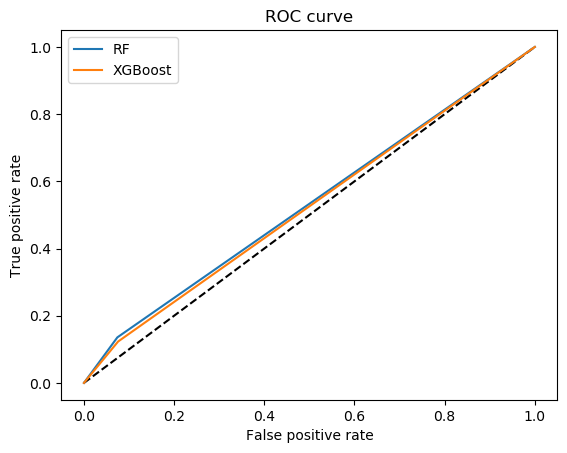

In [17]:
#Roc curves & AUC
rf_a, rf_b, _ = roc_curve(y_test, rf_y_pred)
xgb_a, xgb_b, _ = roc_curve(y_test, xgb_y_pred)

print("AUC_rf : ", metrics.auc(rf_a, rf_b), '\n')
print("AUC_xgb : ", metrics.auc(xgb_a, xgb_b), '\n')

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(rf_a, rf_b, label='RF')
plt.plot(xgb_a, xgb_b, label='XGBoost')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

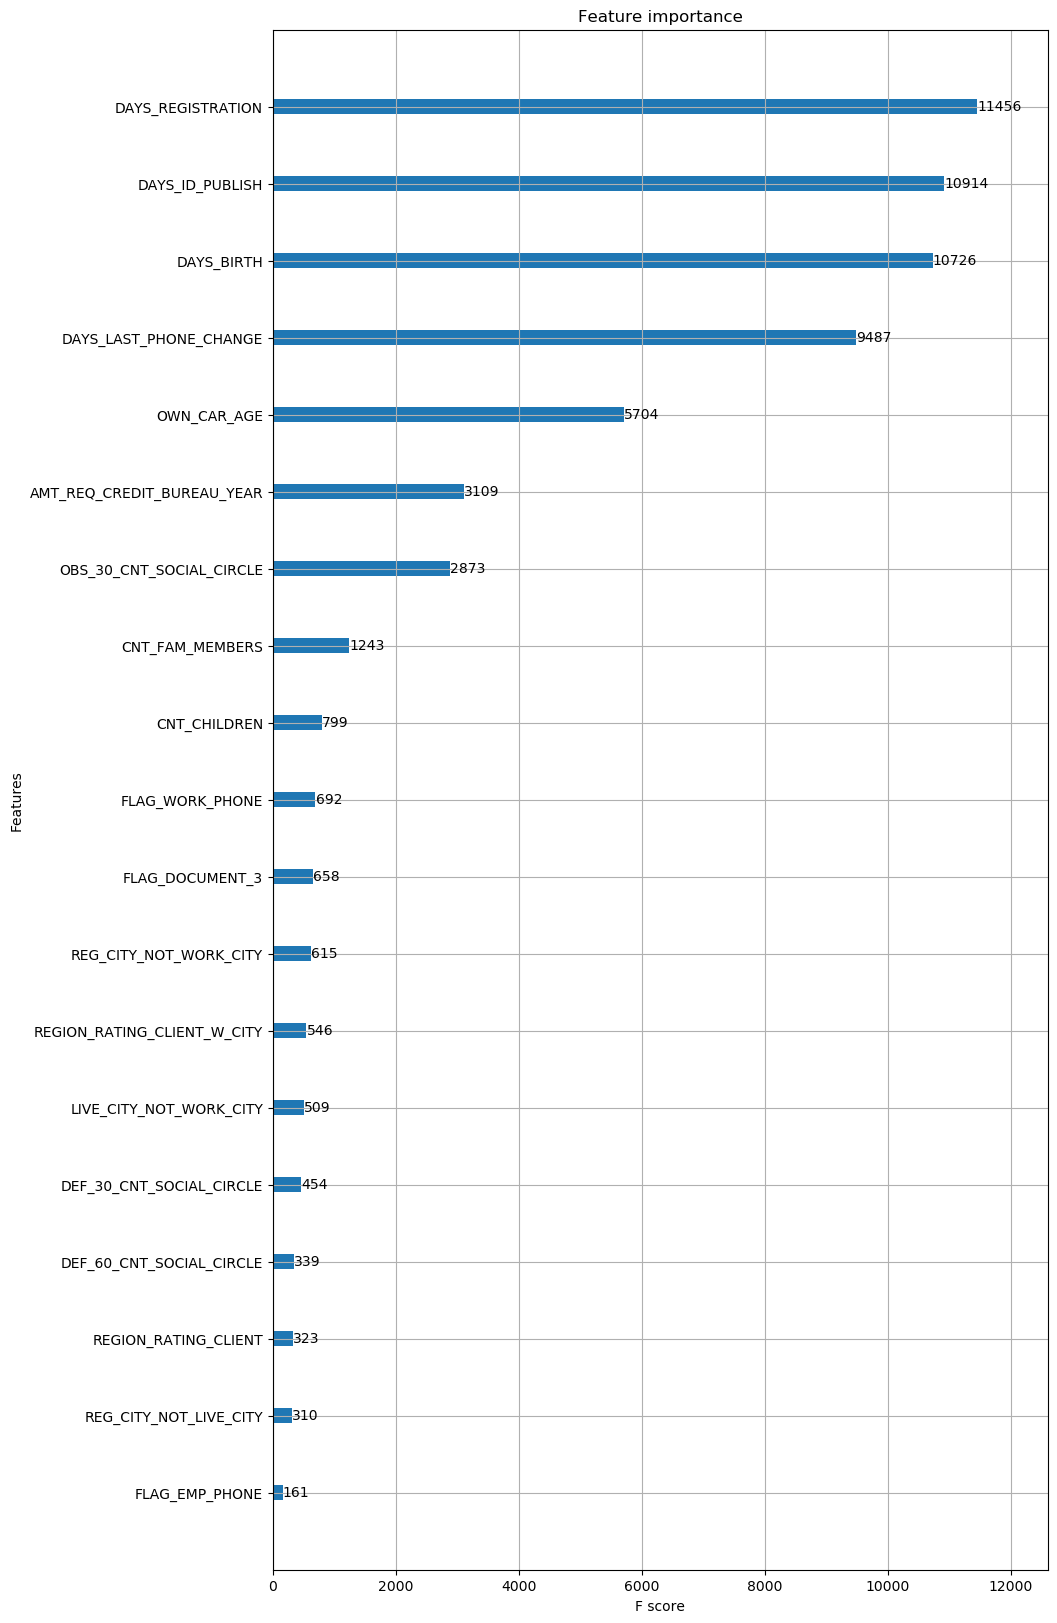

In [18]:
# Plot feature importance for XGBoost
ax = xgboost.plot_importance(xgb, max_num_features = 50)
fig = ax.figure
fig.set_size_inches(10, 20)
plt.show()

# MLFlow

In [27]:
from random import random, randint
from mlflow import log_metric, log_param, log_artifacts

log_param("param1", randint(0, 100))

# Log a metric; metrics can be updated throughout the run
log_metric("foo", random())
log_metric("foo", random() + 1)
log_metric("foo", random() + 2)

# Log an artifact (output file)
if not os.path.exists("outputs"):
    os.makedirs("outputs")
with open("outputs/test.txt", "w") as f:
    f.write("hello world!")
log_artifacts("outputs")


MlflowException: Changing param values is not allowed. Param with key='param1' was already logged with value='55' for run ID='a2580ac732e8421288d558edf294d3d2'. Attempted logging new value '74'.

The cause of this error is typically due to repeated calls
to an individual run_id event logging.

Incorrect Example:
---------------------------------------
with mlflow.start_run():
    mlflow.log_param("depth", 3)
    mlflow.log_param("depth", 5)
---------------------------------------

Which will throw an MlflowException for overwriting a
logged parameter.

Correct Example:
---------------------------------------
with mlflow.start_run():
    with mlflow.start_run(nested=True):
        mlflow.log_param("depth", 3)
    with mlflow.start_run(nested=True):
        mlflow.log_param("depth", 5)
---------------------------------------

Which will create a new nested run for each individual
model and prevent parameter key collisions within the
tracking store.'

# Shap dataviz

In [19]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X)

In [23]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [24]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X.iloc[:1000,:])

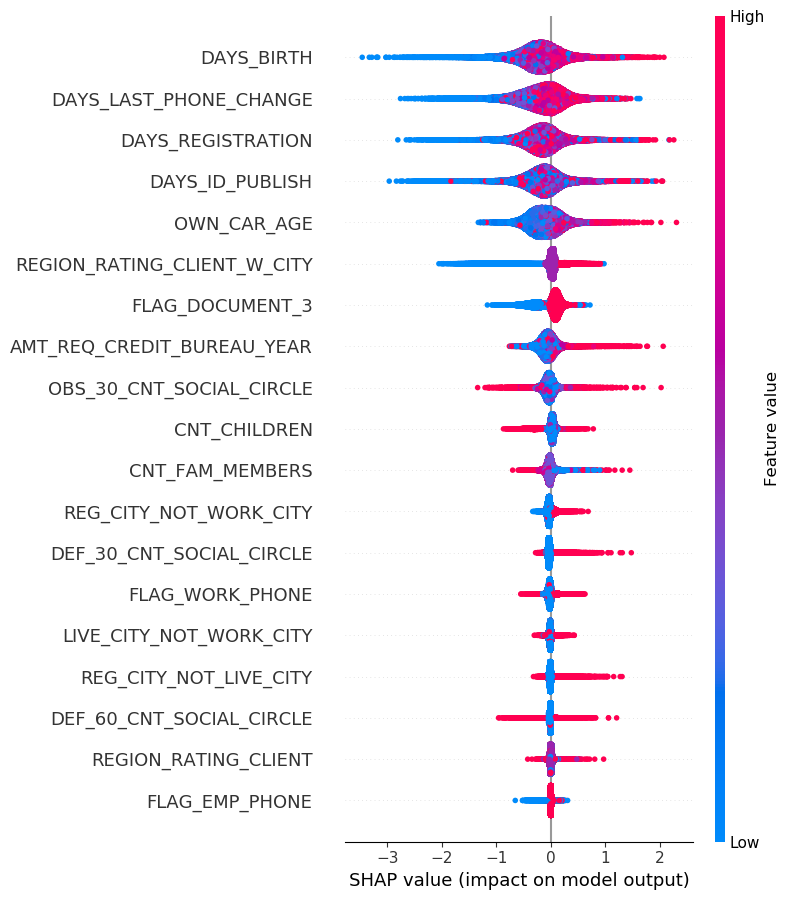

In [22]:
shap.summary_plot(shap_values, X)